In [356]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from keras.models import Sequential , load_model
from keras.layers import LSTM, Dense, Dropout
import os
import tensorflow as tf
from sklearn.metrics import r2_score


In [357]:
api_key = "Jpdzf05nPJhqVB5qpNZx2VbmhwVF1spP"

In [358]:
symbol = "GOOG"
start_date = "2019-08-22"
end_date = "2024-08-26"


url = f'https://api.polygon.io/v2/aggs/ticker/{symbol}/range/1/day/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}'


response = requests.get(url)
data = response.json()


if response.status_code == 200 and 'results' in data:
    df = pd.DataFrame(data['results'])
    df['date'] = pd.to_datetime(df['t'], unit='ms')

    df = df[['date', 'o', 'h', 'l', 'c', 'v', 'vw']]
    df.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']

    print(df.head())
else:
    print("Veri çekilemedi:", data)

                 Date     Open     High      Low    Close      Volume     VWAP
0 2019-08-22 04:00:00  59.7035  59.9006  58.9290  59.4765  18958120.0  59.4246
1 2019-08-23 04:00:00  59.0995  59.7040  57.3875  57.5645  33765420.0  58.0395
2 2019-08-26 04:00:00  57.8630  58.4735  57.6480  58.4445  24528820.0  58.0823
3 2019-08-27 04:00:00  59.0265  59.1200  58.0725  58.3920  21549040.0  58.4520
4 2019-08-28 04:00:00  58.0855  58.8210  57.8650  58.5510  16044860.0  58.4932


In [359]:
data=df
data

,Date,Open,High,Low,Close,Volume,VWAP
0,2019-08-22 04:00:00,59.7035,59.9006,58.9290,59.4765,18958120.0,59.4246
1,2019-08-23 04:00:00,59.0995,59.7040,57.3875,57.5645,33765420.0,58.0395
2,2019-08-26 04:00:00,57.8630,58.4735,57.6480,58.4445,24528820.0,58.0823
3,2019-08-27 04:00:00,59.0265,59.1200,58.0725,58.3920,21549040.0,58.4520
4,2019-08-28 04:00:00,58.0855,58.8210,57.8650,58.5510,16044860.0,58.4932
...,...,...,...,...,...,...,...
1256,2024-08-20 04:00:00,168.7400,170.4100,168.6600,168.9600,11141232.0,169.4324
1257,2024-08-21 04:00:00,166.9900,168.6400,166.5700,167.6300,13913831.0,167.5877
1258,2024-08-22 04:00:00,169.0400,169.4200,165.0300,165.4900,15958113.0,166.4339
1259,2024-08-23 04:00:00,166.5500,167.9500,165.6600,167.4300,13033829.0,167.0864


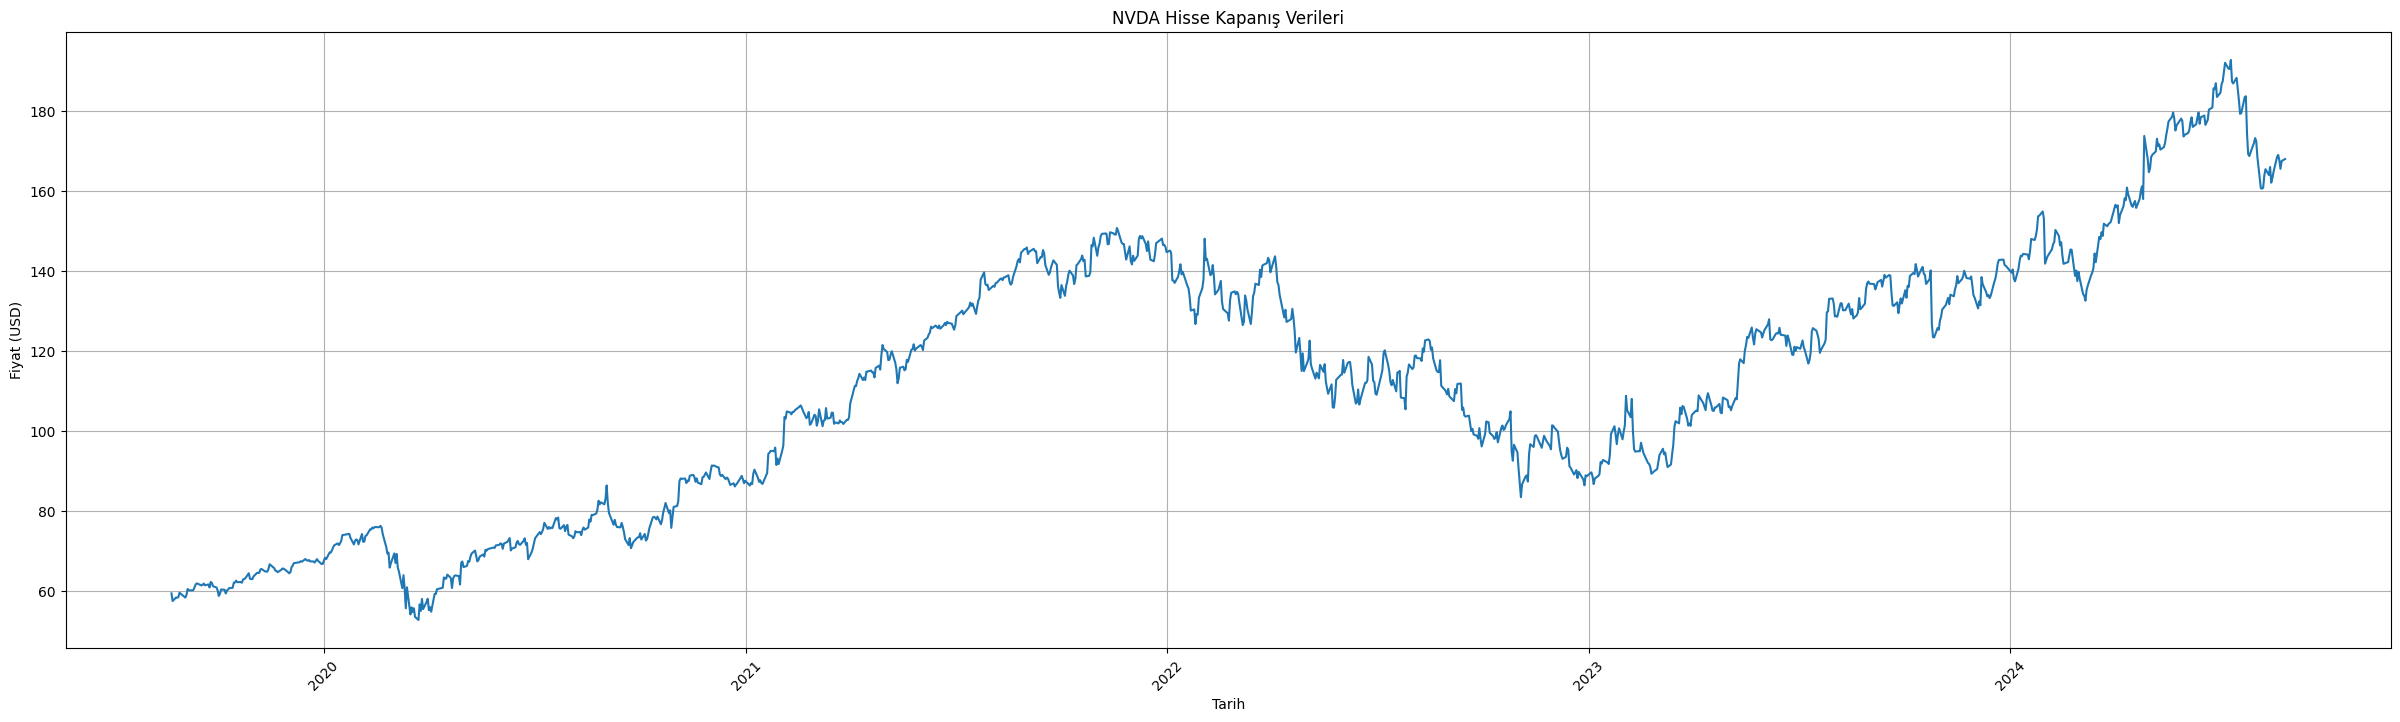

In [360]:
plt.figure(figsize=(30, 8))
plt.plot(df['Date'], df['Close'])  
plt.title("NVDA Hisse Kapanış Verileri")
plt.xlabel("Tarih")
plt.ylabel("Fiyat (USD)")
plt.grid(True)
plt.xticks(rotation=45)  
plt.show()

In [361]:
#100günlük hareketli ortalama grafiği çizdirrelim
ma100 = df.Close.rolling(100).mean() 
ma100

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1256    171.8611
1257    172.0148
1258    172.1047
1259    172.2203
1260    172.3359
Name: Close, Length: 1261, dtype: float64

Text(0.5, 1.0, '100 Günlük hareketli ortalama grafiği')

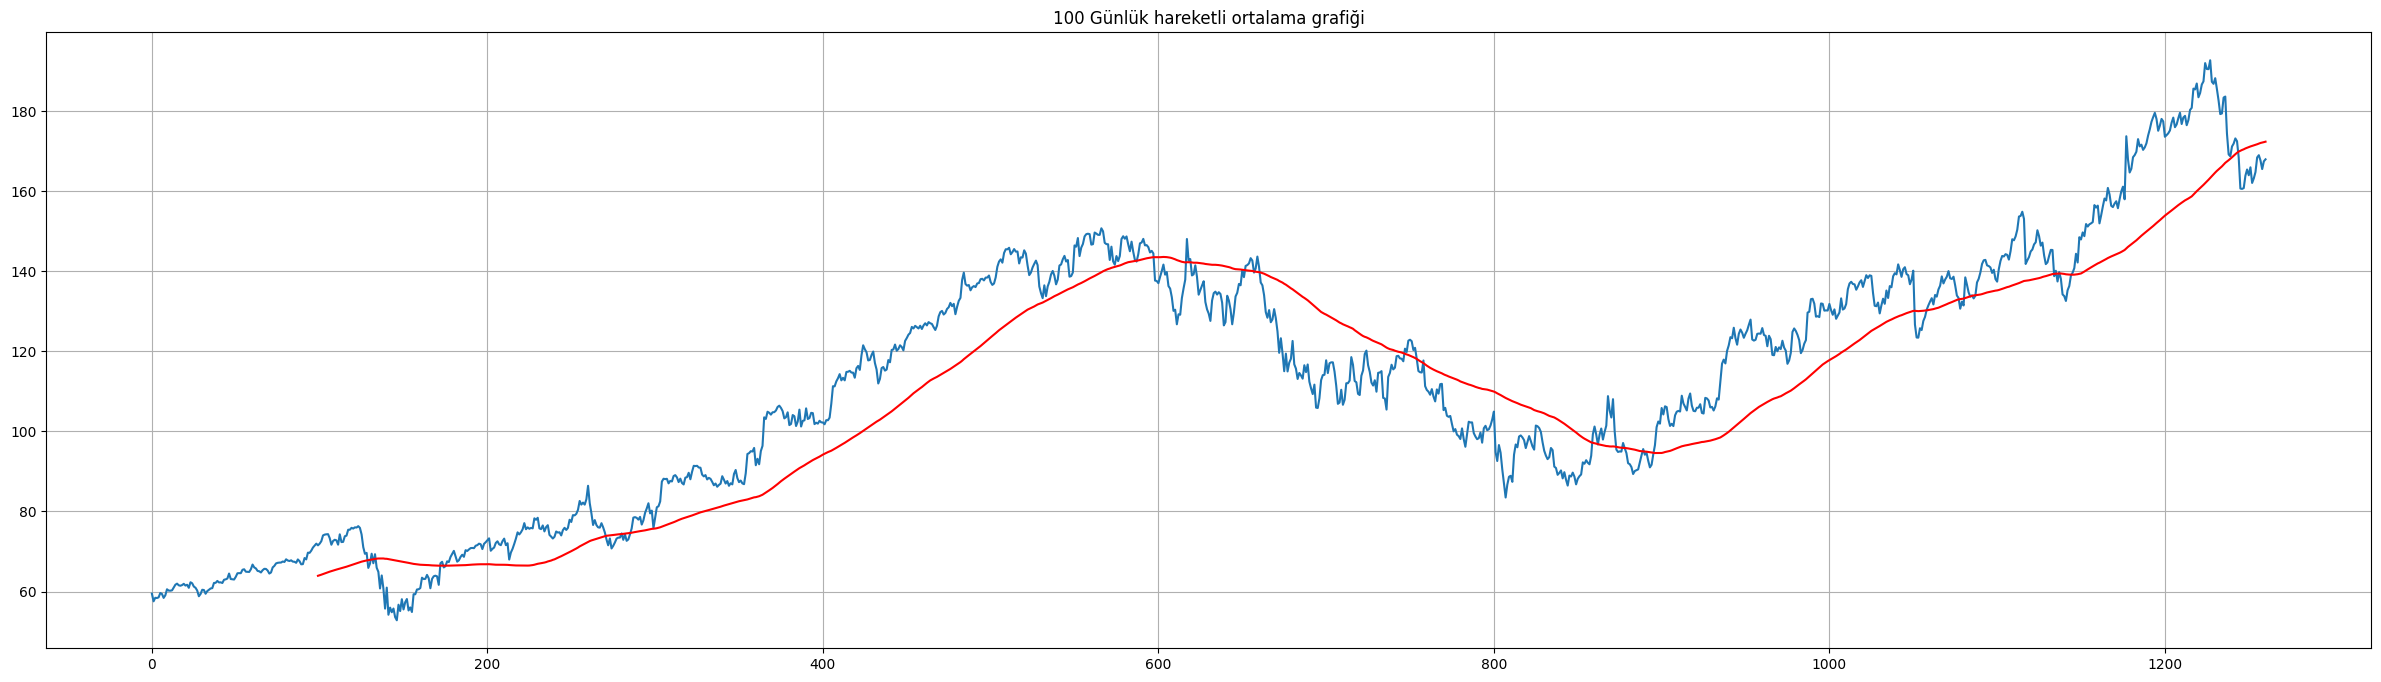

In [362]:
plt.figure(figsize = (30,8))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.grid(True)
plt.title('100 Günlük hareketli ortalama grafiği')

In [363]:
ma50 = df.Close.rolling(50).mean()
ma50

0            NaN
1            NaN
2            NaN
3            NaN
4            NaN
          ...   
1256    176.8446
1257    176.6646
1258    176.4106
1259    176.1680
1260    175.9918
Name: Close, Length: 1261, dtype: float64

Text(0.5, 1.0, '50 günlük hareketli ortalama grafiği')

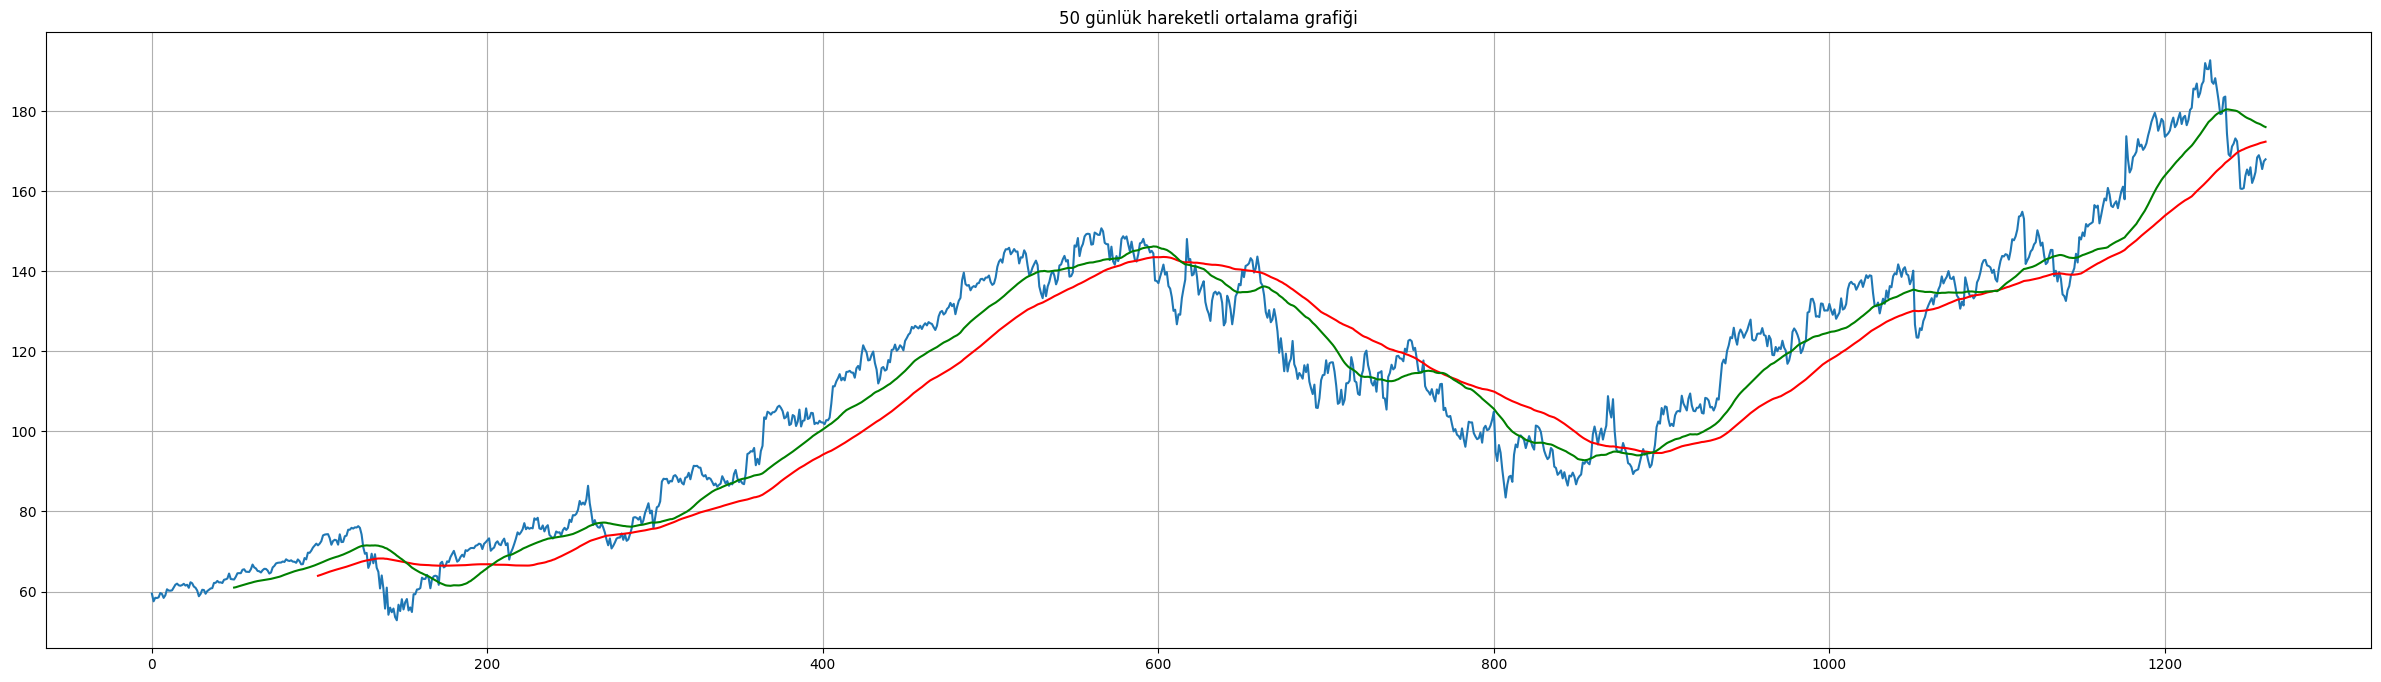

In [364]:
plt.figure(figsize = (30,8))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma50, 'g')
plt.grid(True)
plt.title('50 günlük hareketli ortalama grafiği')

In [365]:
train = pd.DataFrame(data[0:int(len(data)*0.90)])
test = pd.DataFrame(data[int(len(data)*0.90): int(len(data))])

print(train.shape)
print(test.shape)

(1134, 7)
(127, 7)


In [366]:
scaler = MinMaxScaler(feature_range=(0,1))

In [367]:
train_close = train.iloc[:, 4:5].values
test_close = test.iloc[:, 4:5].values

In [368]:
data_training_array = scaler.fit_transform(train_close)
data_training_array

array([[0.06514621],
       [0.04640277],
       [0.05502946],
       ...,
       [0.89216638],
       [0.9066749 ],
       [0.90638081]])

In [369]:
x_train = []
y_train = [] 

for i in range(8, data_training_array.shape[0]): #geçmiş kaç zaman adımını kullancağını belirlemeyi unutma >>>!!!!! lookback
    x_train.append(data_training_array[i-8: i])
    y_train.append(data_training_array[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [370]:
x_train.shape

(1126, 8, 1)

In [371]:
model = Sequential()
model.add(LSTM(units = 50, activation = 'relu', return_sequences=True
              ,input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(units = 60, activation = 'relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units = 80, activation = 'relu', return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(units = 1))

/Users/tbai/Documents/Vsanaliz/analiz/vproject2/lib/python3.9/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [372]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_25 (LSTM)                  │ (None, 8, 50)          │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 8, 50)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_26 (LSTM)                  │ (None, 8, 60)          │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 8, 60)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_27 (LSTM)                  │ (None, 8, 80)          │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 8, 80)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_28 (LSTM)                  │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [373]:
model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[tf.keras.metrics.MeanAbsoluteError()])
model.fit(x_train, y_train,epochs = 100)

Epoch 1/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 321ms/step - loss: 0.2158 - mean_absolute_error: 0.3848
Epoch 2/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 11s 294ms/step - loss: 0.0311 - mean_absolute_error: 0.1459
Epoch 3/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step - loss: 0.0160 - mean_absolute_error: 0.0975
Epoch 4/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 270ms/step - loss: 0.0118 - mean_absolute_error: 0.0825
Epoch 5/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - loss: 0.0110 - mean_absolute_error: 0.0801
Epoch 6/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 271ms/step - loss: 0.0103 - mean_absolute_error: 0.0771
Epoch 7/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 269ms/step - loss: 0.0110 - mean_absolute_error: 0.0793
Epoch 8/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 268ms/step - loss: 0.0095 - mean_absolute_error: 0.0723
Epoch 9/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 273ms/step - loss: 0.0100 - mean_absolute_error: 0.0749
Epoch 10/100
36/36 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step - loss: 0.0091 - mean_absolute_error: 0.0706
Epoch 11/

In [374]:
save_dir = "trained_models_GOOG"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model_path = os.path.join(save_dir, "GOOG_model1.h5")
model.save(model_path)
print(f"NVDA modeli kaydedildi: {model_path}")

NVDA modeli kaydedildi: trained_models_GOOG/GOOG_model1.h5


In [375]:
test_close.shape

(127, 1)

In [376]:
past_100_days = pd.DataFrame(train_close[-100:])

In [335]:
test_df = pd.DataFrame(test_close)

In [336]:
final_df = pd.concat([past_100_days, test_df], ignore_index=True)

In [337]:
final_df.head()

,0
0,44.782
1,43.517
2,44.041
3,44.688
4,45.762


In [338]:
input_data = scaler.fit_transform(final_df)
input_data

array([[0.04678019],
       [0.03349991],
       [0.03900099],
       [0.04579335],
       [0.05706847],
       [0.05193483],
       [0.05744641],
       [0.06802864],
       [0.0694879 ],
       [0.0539085 ],
       [0.06056439],
       [0.03791967],
       [0.01963172],
       [0.01863439],
       [0.01113864],
       [0.02780986],
       [0.03503265],
       [0.01525395],
       [0.        ],
       [0.00182669],
       [0.00876604],
       [0.0047662 ],
       [0.020986  ],
       [0.03338442],
       [0.0491213 ],
       [0.05695299],
       [0.05909463],
       [0.06559305],
       [0.06954039],
       [0.08408046],
       [0.08707246],
       [0.09794864],
       [0.08988599],
       [0.09610095],
       [0.09419027],
       [0.10585382],
       [0.10097214],
       [0.08808029],
       [0.07821194],
       [0.08310412],
       [0.07868436],
       [0.0820333 ],
       [0.0676507 ],
       [0.06759821],
       [0.05442291],
       [0.06550906],
       [0.05434942],
       [0.065

In [339]:
input_data.shape

(227, 1)

In [340]:
x_test = []
y_test = []
for i in range(8, input_data.shape[0]):
   x_test.append(input_data[i-8: i])
   y_test.append(input_data[i, 0])

In [341]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(219, 8, 1)
(219,)


In [342]:
y_pred = model.predict(x_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 131ms/step


In [343]:
y_pred.shape

(219, 1)

In [344]:
scalerNum = scaler.scale_
scalerNum

array([0.01049825])

In [345]:
scale_factor = 1/ scalerNum
y_pred = y_pred * scale_factor
y_test = y_test * scale_factor

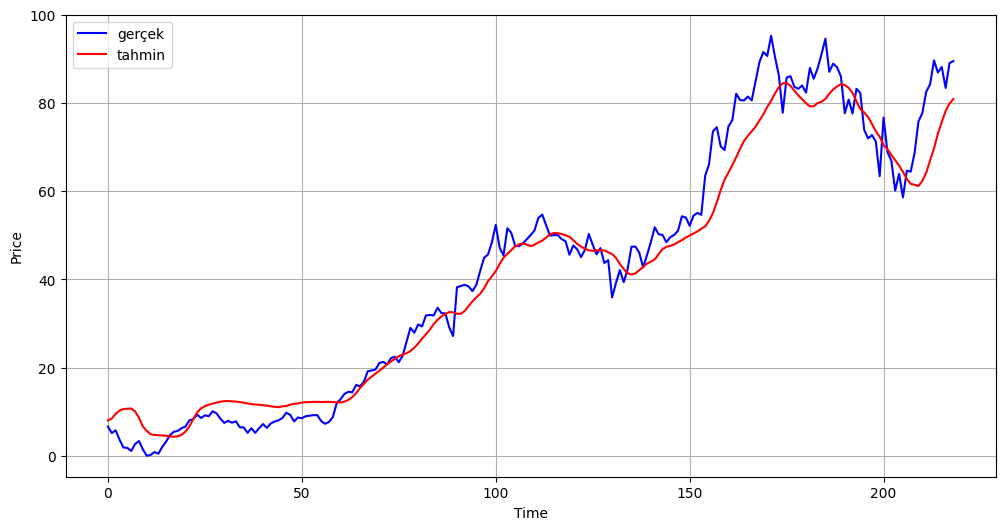

In [350]:
plt.figure(figsize = (12,6))
plt.plot(y_test, 'b', label = "gerçek")
plt.plot(y_pred, 'r', label = "tahmin")
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [355]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, y_pred)
mae_percentage = (mae / np.mean(y_test)) * 100
print("Test setinde ortalama mutlak hata: {:.2f}%".format(mae_percentage))

Test setinde ortalama mutlak hata: 10.93%


In [353]:
actual = y_test

predicted = y_pred
r2 = r2_score(actual, predicted)

print("R2 score:", r2)

R2 score: 0.9565815087499182


# tahminleme

In [254]:
model_path = '/Users/tbai/Documents/Vsanaliz/analiz/project/ABD/trained_models_NVDA/NVDA_model3.h5'
model = load_model(model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


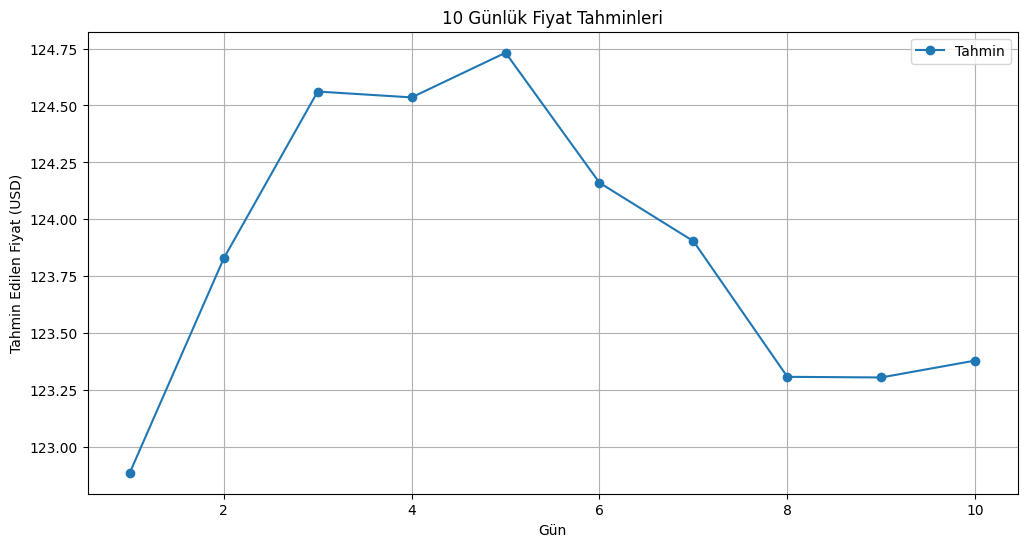

Gün 1: Tahmin Edilen Fiyat = 122.89 USD
Gün 2: Tahmin Edilen Fiyat = 123.83 USD
Gün 3: Tahmin Edilen Fiyat = 124.56 USD
Gün 4: Tahmin Edilen Fiyat = 124.54 USD
Gün 5: Tahmin Edilen Fiyat = 124.73 USD
Gün 6: Tahmin Edilen Fiyat = 124.16 USD
Gün 7: Tahmin Edilen Fiyat = 123.90 USD
Gün 8: Tahmin Edilen Fiyat = 123.31 USD
Gün 9: Tahmin Edilen Fiyat = 123.31 USD
Gün 10: Tahmin Edilen Fiyat = 123.38 USD


In [255]:
past_days = test_close[-100:] 


past_days_scaled = scaler.transform(past_days)


future_days = 10  
predictions = []

for _ in range(future_days):
  
    x_input = past_days_scaled[-8:]  # Son 8 gün verisini kullan
    x_input = np.reshape(x_input, (1, x_input.shape[0], 1))
    

    predicted_price_scaled = model.predict(x_input)
    
    predicted_price = scaler.inverse_transform(predicted_price_scaled)

    predictions.append(predicted_price[0][0])
    

    new_scaled_value = scaler.transform(predicted_price)
    past_days_scaled = np.append(past_days_scaled, new_scaled_value)[1:] 


plt.figure(figsize=(12, 6))
plt.plot(range(1, future_days + 1), predictions, marker='o', label="Tahmin")
plt.title(f"{future_days} Günlük Fiyat Tahminleri")
plt.xlabel("Gün")
plt.ylabel("Tahmin Edilen Fiyat (USD)")
plt.grid(True)
plt.legend()
plt.show()

for i, price in enumerate(predictions, 1):
    print(f"Gün {i}: Tahmin Edilen Fiyat = {price:.2f} USD")